Bank Marketing Campaign

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import display


In [81]:
# Connect to database 

import psycopg2
import pandas as pd
from config import config

import warnings
warnings.filterwarnings('ignore')

def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # read connection parameters
        params = config()

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
    # select all 
        df = pd.read_sql('SELECT * FROM customer',conn)
        # print(df.head())
        return df
        
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')
    

if __name__ == '__main__':
    connect()
    
    

df = connect()



Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 14.2, compiled by Visual C++ build 1914, 64-bit',)
Database connection closed.
Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 14.2, compiled by Visual C++ build 1914, 64-bit',)
Database connection closed.


In [82]:
# Overview   

display(df.shape)
display(df.head(6))
display(df.info())
display(df.describe())

(45211, 17)

,age,job,marital_status,education,default_status,balance,housing,loan,contact,day_of_month,month_name,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45211 non-null  int64 
 1   job             45211 non-null  object
 2   marital_status  45211 non-null  object
 3   education       45211 non-null  object
 4   default_status  45211 non-null  object
 5   balance         45211 non-null  int64 
 6   housing         45211 non-null  object
 7   loan            45211 non-null  object
 8   contact         45211 non-null  object
 9   day_of_month    45211 non-null  int64 
 10  month_name      45211 non-null  object
 11  duration        45211 non-null  int64 
 12  campaign        45211 non-null  int64 
 13  pdays           45211 non-null  int64 
 14  previous        45211 non-null  int64 
 15  poutcome        45211 non-null  object
 16  y               45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


None

,age,balance,day_of_month,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [83]:
df.rename(columns={"y": 'subscribed'}, inplace=True)
display(df.iloc[0,:])


age                       58
job               management
marital_status       married
education           tertiary
default_status            no
balance                 2143
housing                  yes
loan                      no
contact              unknown
day_of_month               5
month_name             may  
duration                 261
campaign                   1
pdays                     -1
previous                   0
poutcome             unknown
subscribed             no   
Name: 0, dtype: object

In [84]:
# Check for duplicates and missing entries  

display(df.duplicated().sum())
display(df.isnull().sum())


0

age               0
job               0
marital_status    0
education         0
default_status    0
balance           0
housing           0
loan              0
contact           0
day_of_month      0
month_name        0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
subscribed        0
dtype: int64

In [85]:
# job types

df['job'].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

In [86]:
# Percentages: marital status, education, default status

display(df.marital_status.value_counts(normalize=True)*100)
display(df.education.value_counts(normalize=True)*100)
display(df.default_status.value_counts(normalize=True)*100)

married     60.193316
single      28.289576
divorced    11.517109
Name: marital_status, dtype: float64

secondary    51.319369
tertiary     29.419831
primary      15.153392
unknown       4.107407
Name: education, dtype: float64

no     98.197341
yes     1.802659
Name: default_status, dtype: float64

Text(0.5, 1.0, 'Distribution of Age by Default Status')

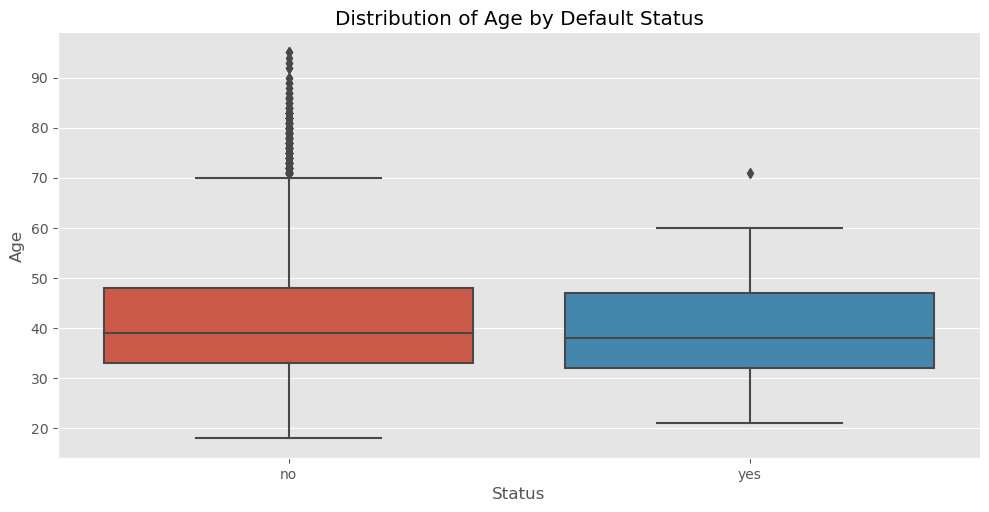

In [87]:
# Boxplots:  default status and age 

plt.style.use('ggplot')
sns.catplot(x="default_status", y="age", data=df, kind="box", aspect=2)
plt.xlabel("Status")
plt.ylabel("Age")
plt.title("Distribution of Age by Default Status")

In [88]:
# Default status grouped by occupation type 

occupation_grp = df.groupby(['job'])
occupation_grp['default_status'].value_counts(normalize=True).head(10)

job           default_status
admin.        no                0.985689
              yes               0.014311
blue-collar   no                0.979346
              yes               0.020654
entrepreneur  no                0.963013
              yes               0.036987
housemaid     no                0.982258
              yes               0.017742
management    no                0.982660
              yes               0.017340
Name: default_status, dtype: float64

Text(0.5, 1.0, 'Age Distribution')

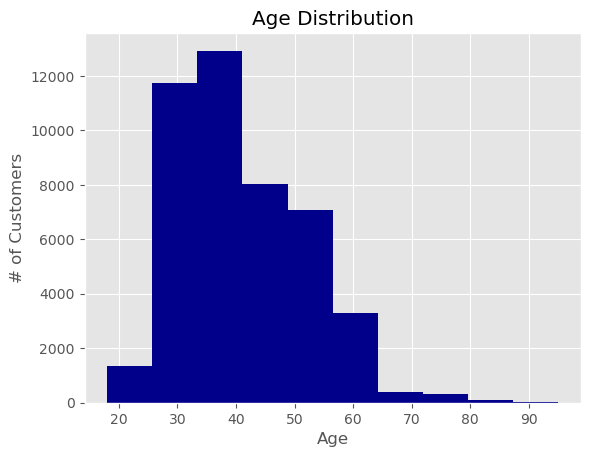

In [89]:
# Distribution of customer age 

fig, ax =plt.subplots()

ax.hist(df['age'], color='darkblue')
ax.set_xlabel('Age')
ax.set_ylabel('# of Customers')
ax.set_title('Age Distribution')

<AxesSubplot: xlabel='balance', ylabel='duration'>

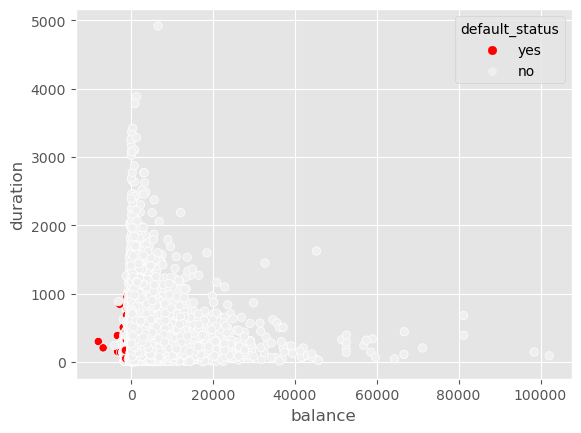

In [90]:
hue_colors = {'yes': 'red', 'no': '#efefef'}
sns.scatterplot(x='balance', y='duration', data=df, hue='default_status', palette=hue_colors, hue_order = ['yes','no'])

Text(0.5, 0.98, 'Default by Balance and Duration')

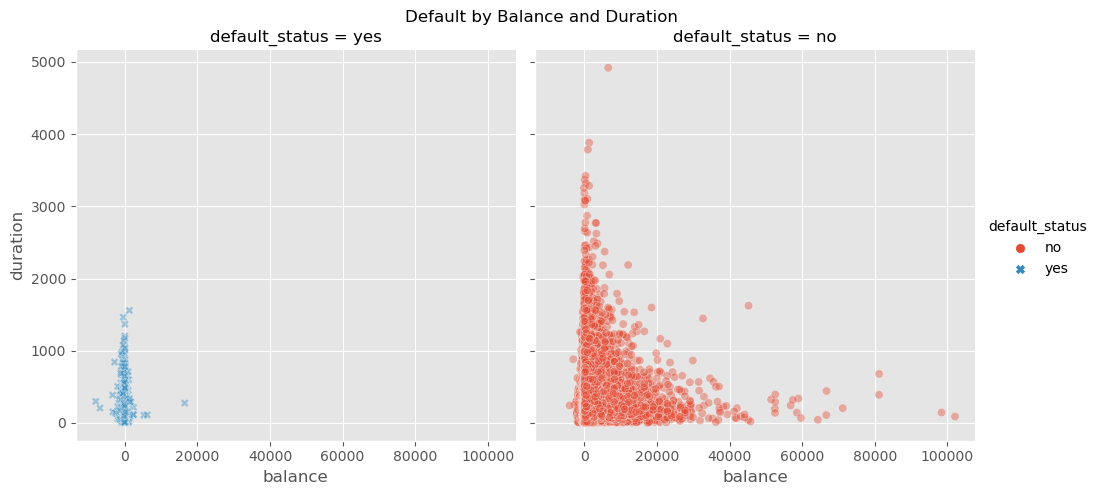

In [91]:
# default status by campaign duration and loan balance 

rp = sns.relplot(x='balance', y='duration', data=df, kind='scatter', col='default_status', 
            col_order=['yes','no'], style='default_status',hue='default_status',alpha=0.4)

rp.fig.subplots_adjust(top=0.9)
rp.fig.suptitle('Default by Balance and Duration')

Text(0.5, 1.0, 'Default Status by Marital Status')

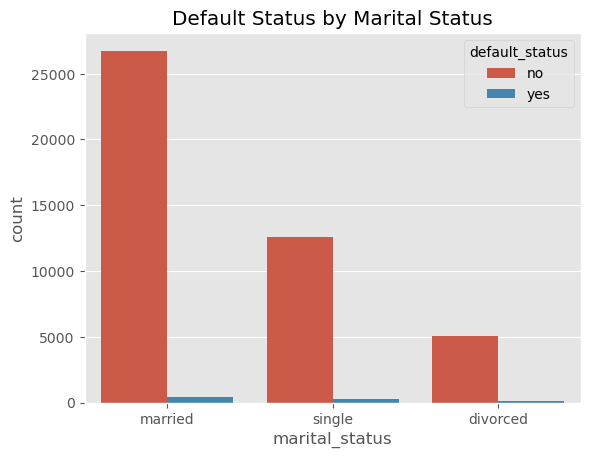

In [92]:
# default by marital status 

sns.countplot(x=df['marital_status'], hue='default_status', data=df).set_title('Default Status by Marital Status')

In [94]:
# select target market list for new campaign 

# there is extra space after the term description outcome 
df['subscribed'] = df['subscribed'].str.strip()

# balances over 25,000 and term deposit subscription is no 
target = df[(df['balance']>25000) & (df['subscribed']=='no')]
target[['age','default_status','balance','loan','duration','pdays','poutcome']].sort_values('pdays', ascending=False).head(10)


,age,default_status,balance,loan,duration,pdays,poutcome
44861,55,no,26306,no,84,589,failure
41798,46,no,37378,no,146,518,failure
35315,53,no,34230,yes,279,358,other
42379,46,no,31630,no,448,214,failure
25783,59,no,32948,no,243,174,failure
34424,34,no,26575,no,245,168,failure
31038,54,no,26306,no,27,84,failure
43953,71,no,29941,no,80,71,other
27327,58,no,26254,no,53,31,failure
29512,59,no,44134,no,117,-1,unknown
